In [1]:
import pandas as pd
import os,sys,codecs,csv,pickle,string
from pprint import pprint
import numpy as np
from funding_analysis import *
import matplotlib.pyplot as plt
import seaborn as sns
import collections

In [3]:
# create a list of the CSV files and the relevant year
csv_files = [f for f in os.listdir() if (f.endswith('.csv') and f.find('_PRJABS_')>-1) ]
csv_files = [(d,s) for d in range(4000) for s in csv_files if s.endswith('FY'+str(d)+'.csv') ]
pprint(csv_files)


[]


In [ ]:
# load the pickle files into two arrays: abstracts and years
abstracts = list()
years = list()
for I in range(len(csv_files)):
    (year,abstract_text_list_of_sets) = decompress_pickle(csv_files[I][1].replace('.csv',''))
    abstracts.append(abstract_text_list_of_sets)
    years.append(year)
    print('Finished loading ', year)
abstracts = np.array(abstracts)
years = np.array(years)
print(years)
print('Saving...',end=' ')
compressed_pickle('all_data___abstracts_years', (years,abstracts))
print( 'finished saving.')

In [26]:
# load single big pickle file w/data from all years
filedir = '/Users/lcarey/Nutstore Files/Nutstore/funding_analysis/'
(years,abstracts) = decompress_pickle(filedir + 'all_data___abstracts_years')


In [ ]:
# count the frequency of each model organism
unique_years = sorted(set(years))
keywords = ['yeast','cancer','zebrafish','elegans','crispr','evolution','xenopus','genome','phase','autophagy']
keywords = ['autophagy','coli','bacteria','antibiotics','antibiotic']
for keyword in keywords:
    for year in unique_years:
        s,p,l = CountGrantsInOneYearWithWord( abstracts[years==year][0] , keyword)
        print(year,keyword,p,sep='\t')
        d = {'year':year, 'keyword':keyword, 'NumGrants':s, 'PctGrants':p, 'TotalGrantsThisYear':l }
        tmp_df = pd.DataFrame(d,index=[0])
        if 'df' in dir():
            df = df.append(tmp_df)
        else:
            df = tmp_df
            
print(df)     



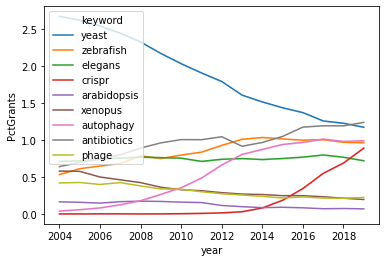

In [73]:
#G.plot(x='year',y='PctGrants',subplots=True,sharey=True)
df2 = df[df.keyword != 'phase']
df2 = df2[df2.keyword != 'cancer']
df2 = df2[df2.keyword != 'genome']
df2 = df2[df2.keyword != 'antibiotic']
df2 = df2[df2.keyword != 'evolution']
df2 = df2[df2.keyword != 'coli']
df2 = df2[df2.keyword != 'bacteria']

#df2 = df2.drop(columns=['NumGrants','TotalGrantsThisYear'])
#df2 = df2.set_index(['year','keyword'])
df2.head()
sns.lineplot(data=df2,x='year',y='PctGrants',hue='keyword')
#plt.show()
#G = df2.groupby(['keyword','year'])
#G.head()
#G.plot()
#plt.ylabel('% of NIH grants with the word')
#plt.xlabel('Year')

In [ ]:
print(len(abstracts[years==year][0]))
print(len(abstracts[years==year] ))
print(list(abstracts[1][1])[:25])  # first 100 words in one abstract in one year

In [ ]:
# find the topics that have decreased the most: 
first_year_abstracts = abstracts[years==min(years)][0]

#first_year_counters = [collections.Counter(W) for W in ]
#counter=collections.Counter(all_words)
#for W in first_year_abstracts:
#    counter = counter +collections.Counter(W)
#len(all_words)
#print(all_words[:100])
#s,p,l = CountGrantsInOneYearWithWord( abstracts[years==min(years)][0] , keyword)


In [145]:
# years is a list of years.  # of elements = # of years
#  abstracts is a list of lists of sets.   
#    # of top-level elements = # of years
#    # of 2nd-level elements = # of grants
#    # each grant is a set of words

df = pd.DataFrame()
#print the year and # of abstracts in each year
for year,abstr in zip(years,abstracts):
    print(year,len(abstr))
    l = list()
    [l.extend(x) for x in abstr]
    counter = collections.Counter( l )
    counter = {k:(100*v/len(abstr)) for k,v in counter.items()}
    tmp_df = pd.DataFrame.from_dict(counter,orient='index',columns=[str(year)])
    df = df.merge(tmp_df,how='outer',left_index=True,right_index=True,copy=False)
    print( df.loc[['yeast']] )
df.fillna(0,inplace=True)    

# remove rows with too few grants
to_remove = df.sum(axis=1)
to_remove = to_remove[to_remove>1]
to_remove.head()
df = df.loc[to_remove.index]

2004 66537
           2004
yeast  2.678209
2005 62938
           2004      2005
yeast  2.678209  2.624805
2006 63595
           2004      2005     2006
yeast  2.678209  2.624805  2.54737
2007 66924
           2004      2005     2006      2007
yeast  2.678209  2.624805  2.54737  2.449047
2008 66487
           2004      2005     2006      2007      2008
yeast  2.678209  2.624805  2.54737  2.449047  2.329779
2009 91625
           2004      2005     2006      2007      2008      2009
yeast  2.678209  2.624805  2.54737  2.449047  2.329779  2.174079
2010 87098
           2004      2005     2006      2007      2008      2009      2010
yeast  2.678209  2.624805  2.54737  2.449047  2.329779  2.174079  2.035638
2011 76673
           2004      2005     2006      2007      2008      2009      2010  \
yeast  2.678209  2.624805  2.54737  2.449047  2.329779  2.174079  2.035638   

           2011  
yeast  1.910712  
2012 71551
           2004      2005     2006      2007      2008      2009      2010

In [ ]:
keywords = ['yeast','microarrays','autophagy','crispr','pluripotent','epigenetic']
df.loc[keywords].transpose().plot()
plt.ylabel('% of grants with the word')
plt.legend(fontsize='x-small')
plt.xlabel('year')
plt.savefig('/Users/lcarey/Downloads/yeast_are_dying.png',dpi=300)

In [143]:
df.head()
first_two_years = np.mean(df.iloc[:,:2],axis=1)
last_two_years = np.mean(df.iloc[:,:-2],axis=1)
ratio = np.log2(last_two_years / first_two_years)

ratio = ratio.sort_values()
for I in ratio.index:
    print(I,ratio[I])

applicants -1.477742183779597
adapted -1.2821751364360008
cloned -1.1082073347096566
percent -0.9902967062024498
cloning -0.9257031493140859
abstract -0.6956115026216757
hybridization -0.6833367250701019
alpha -0.5845660973087858
transduction -0.5834177655123153
mutagenesis -0.5095541758961741
nitric -0.49538024402023983
promoter -0.43640166128581726
synthase -0.43512598993599855
structurefunction -0.43216943089504456
yeast -0.420113422749203
oxide -0.41728262996514903
kinetic -0.41036943232988754
microarrays -0.40077834606375135
linkage -0.3840975492993745
longrange -0.3781245435665456
apoptotic -0.3696213608116397
recombinant -0.3696183378532781
examined -0.3643131342557222
mutants -0.364185121334475
necrosis -0.359812246894416
dominant -0.3597549326787612
unreadable -0.3549381646568664
apoptosis -0.34026734244643
homologous -0.3395179156686516
kinases -0.3391577539657083
microarray -0.3328788283849314
fragments -0.3327287191813024
chromosomal -0.33182877791067467
amino -0.3296536370

In [14]:
l = list()
[l.extend(x) for x in abstracts__list_of_sets[5:]]
counter=collections.Counter(l)
df2 = pd.DataFrame.from_dict(counter,orient='index',columns=[str(year)])
df2.head()


<class 'pandas.core.series.Series'>
